# Task 2 – Dataset Exploration & Visualization (FiftyOne)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
print(os.listdir("/content/drive/MyDrive"))


In [ ]:
os.makedirs("/content/drive/MyDrive/cilp_assessment", exist_ok=True)


In [ ]:
print(os.path.exists("/content/drive/MyDrive/cilp_assessment"))


True


In [ ]:
print(os.listdir("/content/drive/MyDrive"))


In [ ]:
import os

PROJECT_ROOT = "/content/drive/MyDrive/cilp_assessment"
DATA_ROOT = ("/content/drive/MyDrive/BuildingAIAgentsWithMultimodalModels/data/assessment")


In [ ]:
print(os.listdir(DATA_ROOT))


['cubes', 'spheres']


In [ ]:
for cls in ["cubes", "spheres"]:
    print(cls, "->", os.listdir(os.path.join(DATA_ROOT, cls)))


cubes -> ['azimuth.npy', 'zenith.npy', 'lidar', 'rgb']
spheres -> ['azimuth.npy', 'zenith.npy', 'rgb', 'lidar']


In [ ]:
for cls in ["cubes", "spheres"]:
    rgb_count = len(os.listdir(os.path.join(DATA_ROOT, cls, "rgb")))
    lidar_count = len(os.listdir(os.path.join(DATA_ROOT, cls, "lidar")))
    print(cls, rgb_count, lidar_count)


cubes 9999 9999
spheres 752 10029


**Observation 1:**
The dataset is heavily imbalanced, with significantly more cube samples than sphere samples.

**Observation 2:**
For the sphere class, the number of RGB images does not match the number of LiDAR files, indicating incomplete multimodal pairing.

**Observation 3:**
This suggests that careful filtering and balancing of paired RGB–LiDAR samples will be necessary before training to avoid biased models and invalid input pairs.

In [ ]:
from pathlib import Path

def get_valid_pairs(class_name):
    """
    Returns a sorted list of filename stems (without extension)
    that exist in BOTH rgb and lidar folders for a given class.
    """
    rgb_dir = Path(DATA_ROOT) / class_name / "rgb"
    lidar_dir = Path(DATA_ROOT) / class_name / "lidar"

    rgb_files = {p.stem for p in rgb_dir.glob("*.png")}
    lidar_files = {p.stem for p in lidar_dir.glob("*.npy")}

    valid = sorted(rgb_files.intersection(lidar_files))
    return valid


In [ ]:
valid_cubes = get_valid_pairs("cubes")
valid_spheres = get_valid_pairs("spheres")

print("Valid cube pairs:", len(valid_cubes))
print("Valid sphere pairs:", len(valid_spheres))


Valid cube pairs: 9999
Valid sphere pairs: 752


In [ ]:
import random

SEED = 42
random.seed(SEED)

N = min(500, len(valid_spheres))

selected_cubes = random.sample(valid_cubes, N)
selected_spheres = random.sample(valid_spheres, N)

print("Using", N, "samples per class")


Using 500 samples per class


In [ ]:
!pip install -q fiftyone wandb matplotlib seaborn tqdm


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 128.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 158.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.5/934.5 kB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 12.3 MB/s eta

In [ ]:
import fiftyone as fo
import fiftyone.brain as fob


/usr/local/lib/python3.12/dist-packages/glob2/fnmatch.py:141: SyntaxWarning: invalid escape sequence '\Z'
  return '(?ms)' + res + '\Z'


In [ ]:
print(f"FiftyOne version: {fo.__version__}")

FiftyOne version: 1.11.1


In [ ]:
import fiftyone as fo

dataset_name = "cilp_assessment_clean"

if dataset_name in fo.list_datasets():
    fo.delete_dataset(dataset_name)

dataset = fo.Dataset(dataset_name)
dataset.add_group_field("group", default="rgb")


In [ ]:
samples = []

for label, filenames in [
    ("cubes", selected_cubes),
    ("spheres", selected_spheres),
]:
    for stem in filenames:
        rgb_path = os.path.join(DATA_ROOT, label, "rgb", f"{stem}.png")
        lidar_path = os.path.join(DATA_ROOT, label, "lidar", f"{stem}.npy")

        group = fo.Group()

        rgb_sample = fo.Sample(
            filepath=rgb_path,
            group=group.element("rgb"),
            label=fo.Classification(label=label),
        )

        lidar_sample = fo.Sample(
            filepath=lidar_path,
            group=group.element("lidar"),
            label=fo.Classification(label=label),
        )

        samples.extend([rgb_sample, lidar_sample])

dataset.add_samples(samples)
dataset.save()

print(dataset)


 100% |███████████████| 2000/2000 [1.0s elapsed, 0s remaining, 1.9K samples/s]         


INFO:eta.core.utils: 100% |███████████████| 2000/2000 [1.0s elapsed, 0s remaining, 1.9K samples/s]         


Name:        cilp_assessment_clean
Media type:  group
Group slice: rgb
Num groups:  1000
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    group:            fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.groups.Group)
    label:            fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)


In [ ]:
dataset.stats()

{'samples_count': 2000,
 'samples_bytes': 794000,
 'samples_size': '775.4KB',
 'total_bytes': 794000,
 'total_size': '775.4KB'}

In [ ]:
import fiftyone as fo

session = fo.launch_app(dataset, auto=False)
print(session.url)


Session launched. Run `session.show()` to open the App in a cell output.


INFO:fiftyone.core.session.session:Session launched. Run `session.show()` to open the App in a cell output.



Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.11.1

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Discord community 🚀🚀🚀
|  https://community.voxel51.com/
|



INFO:fiftyone.core.session.session:
Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.11.1

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Discord community 🚀🚀🚀
|  https://community.voxel51.com/
|



https://5151-gpu-t4-s-8w19gfu1frah-a.asia-southeast1-1.prod.colab.dev?polling=true


In [ ]:
from collections import Counter

# Count groups per class
group_labels = {}

for sample in dataset.select_group_slices("rgb"):
    group_id = sample.group.id
    label = sample.label.label
    group_labels[group_id] = label

class_counts = Counter(group_labels.values())

print("Total number of groups per class:")
for cls, cnt in class_counts.items():
    print(f"{cls}: {cnt}")


Total number of groups per class:
cubes: 500
spheres: 500


In [ ]:
import random

SEED = 42
random.seed(SEED)

group_ids = list(group_labels.keys())
random.shuffle(group_ids)

split_ratio = 0.8
split_idx = int(len(group_ids) * split_ratio)

train_groups = set(group_ids[:split_idx])
val_groups = set(group_ids[split_idx:])

print("Train groups:", len(train_groups))
print("Validation groups:", len(val_groups))


Train groups: 800
Validation groups: 200


In [ ]:
for sample in dataset:
    if sample.group.id in train_groups:
        sample.tags.append("train")
    else:
        sample.tags.append("val")
    sample.save()


In [ ]:
print("Train samples:", dataset.match_tags("train").count())
print("Validation samples:", dataset.match_tags("val").count())


Train samples: 800
Validation samples: 200


In [ ]:
dataset.compute_metadata()

rgb_samples = dataset.select_group_slices("rgb")

widths = rgb_samples.values("metadata.width")
heights = rgb_samples.values("metadata.height")
dtypes = rgb_samples.values("metadata.mime_type")

print("RGB image dimensions:")
print("Min width:", min(widths), "Max width:", max(widths))
print("Min height:", min(heights), "Max height:", max(heights))

print("RGB data types (mime):", set(dtypes))


Computing metadata...


INFO:fiftyone.core.metadata:Computing metadata...


 100% |███████████████| 2000/2000 [7.0m elapsed, 0s remaining, 3.7 samples/s]       


INFO:eta.core.utils: 100% |███████████████| 2000/2000 [7.0m elapsed, 0s remaining, 3.7 samples/s]       


RGB image dimensions:
Min width: 64 Max width: 64
Min height: 64 Max height: 64
RGB data types (mime): {'image/png'}


In [ ]:
RESULTS_DIR = "/content/drive/MyDrive/cilp_assessment/results"

In [ ]:
import os
os.makedirs(RESULTS_DIR, exist_ok=True)

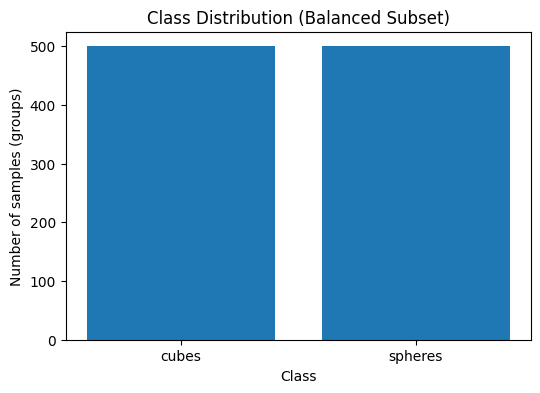

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class")
plt.ylabel("Number of samples (groups)")
plt.title("Class Distribution (Balanced Subset)")

plt.savefig(os.path.join(RESULTS_DIR, "class_distribution.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()


In [ ]:
from pathlib import Path

raw_counts = {}

for cls in ["cubes", "spheres"]:
    rgb_dir = Path(DATA_ROOT) / cls / "rgb"
    lidar_dir = Path(DATA_ROOT) / cls / "lidar"

    raw_counts[cls] = {
        "rgb": len(list(rgb_dir.glob("*.png"))),
        "lidar": len(list(lidar_dir.glob("*.npy"))),
    }

print("Raw dataset counts (before cleaning):")
for cls, counts in raw_counts.items():
    print(f"{cls}: RGB = {counts['rgb']}, LiDAR = {counts['lidar']}")


Raw dataset counts (before cleaning):
cubes: RGB = 9999, LiDAR = 9999
spheres: RGB = 752, LiDAR = 10029


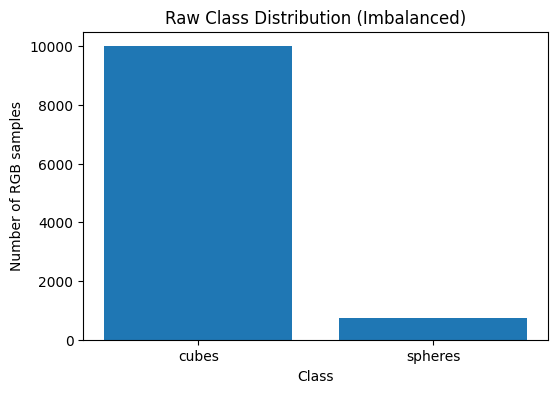

In [ ]:
import matplotlib.pyplot as plt

classes = list(raw_counts.keys())
rgb_counts = [raw_counts[c]["rgb"] for c in classes]

plt.figure(figsize=(6,4))
plt.bar(classes, rgb_counts)
plt.xlabel("Class")
plt.ylabel("Number of RGB samples")
plt.title("Raw Class Distribution (Imbalanced)")

plt.savefig(os.path.join(RESULTS_DIR, "raw_class_distribution.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()


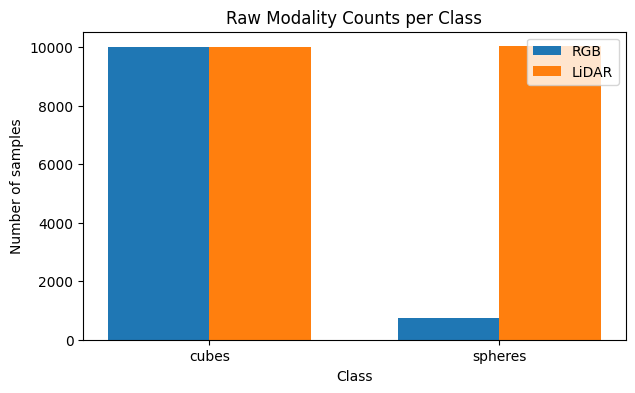

In [ ]:
import numpy as np

x = np.arange(len(classes))
width = 0.35

rgb_vals = [raw_counts[c]["rgb"] for c in classes]
lidar_vals = [raw_counts[c]["lidar"] for c in classes]

plt.figure(figsize=(7,4))
plt.bar(x - width/2, rgb_vals, width, label="RGB")
plt.bar(x + width/2, lidar_vals, width, label="LiDAR")

plt.xticks(x, classes)
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Raw Modality Counts per Class")
plt.legend()

plt.savefig(os.path.join(RESULTS_DIR, "raw_modality_counts.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()


In [ ]:
valid_raw_counts = {
    "cubes": len(get_valid_pairs("cubes")),
    "spheres": len(get_valid_pairs("spheres")),
}

print("Valid paired samples (raw dataset):")
for cls, cnt in valid_raw_counts.items():
    print(f"{cls}: {cnt}")


Valid paired samples (raw dataset):
cubes: 9999
spheres: 752


In [ ]:
import wandb
wandb.login()



/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jain5 (jain5-university-of-potsdam) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
wandb.init(
    project="cilp-extended-assessment",
    name="task1_sanity_run",
    config={
        "batch_size": 32,
        "learning_rate": 1e-3,
        "epochs": 1,
        "optimizer": "Adam",
        "architecture": "N/A",
        "fusion_strategy": "single_modality",
    }
)


In [ ]:
wandb.log({
    "train_loss": 1.23,
    "val_loss": 1.45,
    "learning_rate": 1e-3,
})


In [ ]:
wandb.finish()


learning_rate,▁
train_loss,▁
val_loss,▁
learning_rate,0.001
train_loss,1.23
val_loss,1.45
